In [80]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [83]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

# test 
X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=['0','1'], full_MNIST=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)

X_train.shape (11834, 784)
X_test.shape (2946, 784)
y_train.shape (11834, 2)
y_test.shape (2946, 2)
y_test [[0 1]
 [1 0]
 [0 1]
 ...
 [1 0]
 [1 0]
 [0 1]]


## Plot some common activation functions

In [84]:
# sigmoid and logit function 
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def ReLU(x):
    return np.maximum(0,x)

def tanh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

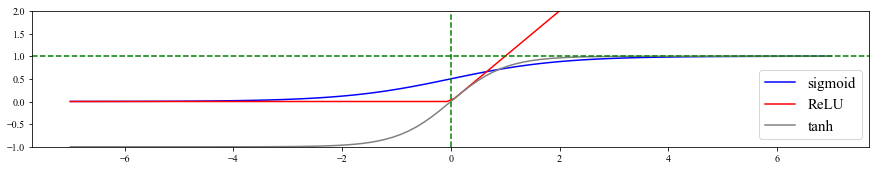

In [85]:
# plot sigmoid function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,2.5])
x = np.linspace(-7, 7, 100)
ax.plot(x, sigmoid(x), color='blue', label="sigmoid")
ax.plot(x, ReLU(x), color='red', label="ReLU")
ax.plot(x, tanh(x), color='gray', label="tanh")
ax.set_ylim(-1,2)

plt.axhline(y=1, color='g', linestyle='--')
plt.axvline(x=0, color='g', linestyle='--')
ax.legend(fontsize=15)
plt.savefig('activation.pdf', bbox_inches='tight')

## Define Class FFNN 

In [172]:
class FFNN():

    def __init__(self,
                 list_hidden_layer_sizes = [30], # hidden1, hidden2, .. , hidden h
                 loss_function = 'softmax-cross-entropy', # or 'square' or 'cross-entropy'
                 activation_list = None, # ['ReLU', 'sigmoid'],
                 node_states = None,
                 weight_matrices = None,
                 training_set = [None, None]): # input = [feature_dim x samples], output [\kappa x samples]
                 
        self.training_set = training_set
        # self.test_set = test_set
        self.list_layer_sizes = [self.training_set[0].shape[0]] + list_hidden_layer_sizes + [self.training_set[1].shape[0]]
        self.loss_function = loss_function
        self.n_layers = len(self.list_layer_sizes)-1
        self.activation_list = activation_list
        self.node_states = node_states
        self.weight_matrices = weight_matrices
        
        self.initialize()
        
       
    def initialize(self):
        if self.activation_list is None:
            activation_list = ['ReLU' for i in np.arange(len(self.list_layer_sizes)-1)]
            activation_list[-1] = 'sigmoid'
            self.activation_list = activation_list

        if self.node_states == None:
            node_states = []
            for i in np.arange(len(self.list_layer_sizes)):
                node_states.append(np.zeros(shape=[self.list_layer_sizes[i], ]))
            self.node_states = node_states
        
        if self.weight_matrices == None:
            weight_matrices = []
            for i in np.arange(len(self.activation_list)):
                U = np.random.rand(self.list_layer_sizes[i], self.list_layer_sizes[i+1]) 
                weight_matrices.append(1-2*U)
            self.weight_matrices = weight_matrices

       
    def forward_propagate(self, input_data):
        # Forward propagate the input using the current weights and update node states 
        self.node_states[0] = input_data
        for i in np.arange(self.n_layers):    
            X_new = self.node_states[i].T @ self.weight_matrices[i]
            X_new = activation(X_new, type=self.activation_list[i])
            self.node_states[i+1] = X_new
            # print('!!! X_new', X_new)
        
    def backpropagate(self, output_data):
        # Backpropagate the error and return the gradient of the weight matrices
        # output_data = column array
        node_errors = self.node_states.copy()

        y = output_data
        y_hat = self.node_states[-1] # shape (\kappa, )
        y_hat = y_hat[:, np.newaxis]
        node_errors[-1] = delta_loss_function(y=y, y_hat=y_hat, type=self.loss_function)
        W_grad = self.weight_matrices.copy()
        
        for i in range(self.n_layers -1, -1, -1):
            # First weight the errors of nodes in layer above by the derivative of activation
            wtd_errors = node_errors[i+1].copy() 
            z = self.node_states[i][:,np.newaxis]
            W = self.weight_matrices[i]
            layer_size_above = self.list_layer_sizes[i+1]
            delta_activation_weights = [delta_activation(z.T @ W[:,q], type=self.activation_list[i]) for q in np.arange(layer_size_above)]
            delta_activation_weights = np.asarray(delta_activation_weights)
            if len(delta_activation_weights.shape)==1:
                delta_activation_weights = delta_activation_weights[:,np.newaxis] 
            if len(wtd_errors.shape)==1:
                wtd_errors = wtd_errors[:,np.newaxis] 
        
            wtd_errors = wtd_errors * delta_activation_weights
            # wtd_errors = wtd_errors[:, np.newaxis]

            # Compute the gradient of the i th weight matrix (conneting layer i and i+1)
            W_grad[i] = wtd_errors @ z.T  
            
            # Propagate it backward onto layer i
            node_errors[i] = (W @ wtd_errors)[:,0]
        return W_grad
    
    def minibatch_grad(self, minibatch_idx):
        
        W_grad_list = []
        Y = self.training_set[1] # true labels: each column = one-hot encoding
        X = self.training_set[0]
        for i in minibatch_idx:
            self.forward_propagate(input_data=X[:,i])
            y = Y[:, i]
            y = y[:, np.newaxis]
            W_grad = self.backpropagate(output_data=y)
            W_grad_list.append(W_grad)
            
        W_grad_minibatch = self.weight_matrices.copy()
        for j in np.arange(self.n_layers):
            grad_temp = [W_grad_list[i][j] for i in np.arange(len(minibatch_idx))]
            W_grad_minibatch[j] = np.sum(np.asarray(grad_temp), axis=0)
            
        return W_grad_minibatch
        
    def train(self, n_SGD_iter=10, minibatch_size=1, stopping_diff=0.01):
        Y = self.training_set[1]
        for i in np.arange(n_SGD_iter):
            # compute the minibatch gradients of weight matrices 
            num_train_data = Y.shape[0]
            minibatch_idx = np.random.choice(np.arange(num_train_data), minibatch_size)
            W_grad_minibatch = self.minibatch_grad(minibatch_idx=minibatch_idx)
            
            # GD 
            for j in np.arange(self.n_layers):
                W1 = self.weight_matrices[j]
                t = 0
                grad = W_grad_minibatch[j].T
                if (np.linalg.norm(grad) > stopping_diff):
                    W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
                self.weight_matrices[j] = W1.copy()
                if j == 0:
                    print('SGD epoch = %i, grad_norm = %f' %(i, np.linalg.norm(grad)))
        
    def predict(self, test_set, normalize=False):
        y_pred = []
        for i in np.arange(test_set.shape[1]):
            self.forward_propagate(input_data=test_set[:,i])
            y_hat = self.node_states[-1].copy()
            if normalize:
                y_hat /= np.sum(y_hat)
            y_pred.append(y_hat)
            # print('!! y_hat', y_hat)
        return y_pred
            
        
### Helper functions

def loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    if type == 'cross_entropy':
        return cross-entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return (1/2) * (y_hat - y).T @ (y_hat - y)
   

def delta_loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    # return delta_cross_entropy(y=y, y_hat=y_hat/np.sum(y_hat))
    
    if type == 'cross-entropy':
        return delta_cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return y_hat - y
    elif type == 'softmax-cross-entropy':
        return softmax(y_hat) - y

        
def activation(x, type='sigmoid'):
    if type == 'sigmoid':
        return 1/(1+np.exp(-x))
    elif type == 'ReLU':
        return np.maximum(0,x)
    elif type == 'tanh':
        return (np.exp(2*x)-1)/(np.exp(2*x)+1)

def delta_activation(x, type='sigmoid'):
    # derivate of activation function
    if type == 'sigmoid':
        return sigmoid(x)*(1-sigmoid(x))
    elif type == 'ReLU':
        return int((x>0))
    elif type == 'tanh':
        return (2/(np.exp(x)+np.exp(-x)))**2
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)

def tanh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

def ssoftmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    z = (y.T @ np.log(y_hat))[0][0]
    return (y.T @ np.log(y_hat))[0][0]

def delta_cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    y_hat /= np.max(y_hat)
    z = y.copy()
    for i in np.arange(y.shape[0]):
        a = y.argmax(axis=0)[0]
        z[i,0] = -1/y_hat[a, 0]
    return z

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

def softmax(a):
    """
    given an array a = [a_1, .. a_k], compute the softmax distribution p = [p_1, .. , p_k] where p_i \propto exp(a_i)
    """
    a1 = a - np.max(a)
    p = np.exp(a1)
    if type(a) is list:
        p = p/np.sum(p)
    else: 
        row_sum = np.sum(p, axis=1)
        p = p/row_sum[:, np.newaxis]
    return p

In [173]:
FFNN = FFNN(list_hidden_layer_sizes = [30], # hidden1, hidden2, .. , hidden h
                 loss_function = 'softmax-cross-entropy', # 'cross-entropy' or 'square'
                 activation_list = None, # ['ReLU', 'sigmoid'],
                 node_states = None,
                 weight_matrices = None,
                 training_set = [X_train.T/500, y_train.T]) # input = [N x ], output 


In [174]:
FFNN.list_layer_sizes

[784, 30, 2]

In [175]:
FFNN.train(n_SGD_iter=40, minibatch_size=1000, stopping_diff=0.01)

SGD epoch = 0, grad_norm = 6.181812
SGD epoch = 1, grad_norm = 6.180917
SGD epoch = 2, grad_norm = 10.025158
SGD epoch = 3, grad_norm = 17.859440
SGD epoch = 4, grad_norm = 5.357916
SGD epoch = 5, grad_norm = 1.190363
SGD epoch = 6, grad_norm = 0.777284
SGD epoch = 7, grad_norm = 0.585844
SGD epoch = 8, grad_norm = 0.459417
SGD epoch = 9, grad_norm = 0.389665
SGD epoch = 10, grad_norm = 0.340057
SGD epoch = 11, grad_norm = 0.303101
SGD epoch = 12, grad_norm = 0.252435
SGD epoch = 13, grad_norm = 0.235867
SGD epoch = 14, grad_norm = 0.214375
SGD epoch = 15, grad_norm = 0.205210
SGD epoch = 16, grad_norm = 0.186954
SGD epoch = 17, grad_norm = 0.179365
SGD epoch = 18, grad_norm = 0.168213
SGD epoch = 19, grad_norm = 0.151192
SGD epoch = 20, grad_norm = 0.148244
SGD epoch = 21, grad_norm = 0.137716
SGD epoch = 22, grad_norm = 0.132654
SGD epoch = 23, grad_norm = 0.130307
SGD epoch = 24, grad_norm = 0.122705
SGD epoch = 25, grad_norm = 0.118524
SGD epoch = 26, grad_norm = 0.114783
SGD epoch

In [177]:
y_pred = FFNN.predict(X_test.T/200, normalize=True)

In [178]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix \n ===>', mcm)
            
    return results_dict

In [182]:
# compute binary classification metrics on test data

y_test_label = np.asarray(onehot2list(y_test))
P_pred=np.asarray([p[1] for p in y_pred])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)

AUC ===> 0.991
Opt_threshold ===> 0.614
Accuracy ===> 0.970
Sensitivity ===> 0.943
Specificity ===> 0.994
Precision ===> 0.952
Fall_out ===> 0.057
Miss_rate ===> 0.006
Confusion matrix 
 ===> [[1299   79]
 [   9 1559]]


{'Y_test': array([1, 0, 1, ..., 0, 0, 1]),
 'Y_pred': array([1., 0., 1., ..., 0., 0., 1.]),
 'AUC': 0.9909066674565327,
 'Opt_threshold': 0.6142123610633841,
 'Accuracy': 0.9701289884589274,
 'Sensitivity': 0.9426705370101597,
 'Specificity': 0.9942602040816326,
 'Precision': 0.9517704517704517,
 'Fall_out': 0.057329462989840346,
 'Miss_rate': 0.005739795918367347,
 'Confusion_mx': array([[1299,   79],
        [   9, 1559]])}